# Shopee-Product-Matching
![Shopee](https://cdn.lynda.com/course/563030/563030-636270778700233910-16x9.jpg)


* Similar to images, we can use pretrained neural network-based model in order to extract Text embeddings for sentences. One of the popular is for sure **BERT**.

* Some High Level Explanation For **ArcFace Loss** borrowed from [eneszvo's notebook](https://www.kaggle.com/code/eneszvo/shopee-summary-efficientnet-arcface-bert#Pretrained-embedding)


# ArcFace embedding

Modification that forces similar class embeddings to be closer and dissimilar more distant. The simple example with MNIST https://www.kaggle.com/slawekbiel/arcface-explained/.

Basically, it modifies the softmax loss function in order to achieve better separation for different classes in the embedding space. To understand the formula lets first recall cross-entropy loss and softmax definition.

**Cross-entropy loss** - measures the performance of a classification model whose output is a probability value between 0 and 1. Usually used for multi-class classification. 
$$CE = -\sum_{i=1}^{C} t_{i}\log(a_{i})$$
where $C$ is the number of classes, $t$ is mostly a one-hot vector (or binary vector for multi-label classification) representing labels, and $a$ activation function (usually the output function in the NN).

**Softmax function** - the activation function in the output layer of neural network models that predict a multinomial probability distribution.
$$ softmax(x_{i}) = \frac{e^{x_{i}}}{\sum_{j=1}^{n} e^{x_{j}}}$$
where $x$ is $n$-dimensional vector.

**Softmax loss** - cross-entropy loss applied on softmax activation function,
$$CE = -\sum_{i=1}^{C} t_{i}\log(a_{i}) = -\sum_{i=1}^{C} t_{i}\log(\frac{e^{x_{i}}}{\sum_{j=1}^{n} e^{x_{j}}}).$$

If $t=(t_{1}, t_{2},..., t_{C})$ is one-hot vector where $t_{i}=1$, then softmax loss becomes
$$CE = -\log(\frac{e^{x_{i}}}{\sum_{j=1}^{n} e^{x_{j}}}).$$

**Softmax cost** function is the average of the loss functions over the training set (or batch), 
$$CE = -\frac{1}{N}\sum_{i=1}^{N}\log(\frac{e^{x_{i}}}{\sum_{j=1}^{n} e^{x_{j}}}).$$
Based on the figure below,

**softmax cost** can be written as
$$CE = -\frac{1}{N}\sum_{i}^{N}\log(\frac{e^{W_{y_{i}}^{T}x_{i} + b_{y_{i}}}}{\sum_{j=1}^{n} e^{W_{j}^{T}x_{i} + b_{j}}}).$$
where $x_{i}$ denotes embedding of the $i$-th sample, belonging to the $y_{i}$-th class (from the image above, $y_{i}=2$). $W_{j}$ denotes the $j$-th column of the weight matrix $W$.

Lets fix $b=\mathbf{0}$, normalize all weight columns $\Vert W_{j}\Vert=1$ and normalize embedding vector $\Vert x\Vert=1$. After normalization, embedding will be distributed on a unit hypersphere. Now we have that 
$$W_{j}^{T}x + b_{j}=\frac{W_{j}^{T}x}{\Vert W_{j}\Vert\Vert x\Vert} = \cos(\langle W_{j}^{T}, x\rangle)=\cos(\theta_{j}).$$

Further, we can easily get $\theta$ angle applying $\arccos$ to both sides and after increase $\theta$ by penalty $m$. From the ArcFace paper https://arxiv.org/pdf/1801.07698.pdf, autors explained it as:  
> We add an additive angular margin penalty $m$ between $x_{i}$ and $W_{y_{i}}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy.

After all, the softmax cost becomes 
$$CE = -\frac{1}{N}\sum_{i}^{N}\log(\frac{e^{s \cos(\theta_{y_{i}}+m)}}{e^{s \cos(\theta_{y_{i}}+m)} + \sum_{j=1, j\neq y_{i}}^{n} e^{s \cos(\theta_{j})}})$$
where $s$ is a scaler that defines the radius of hypersphere where embeddings are distributed. 

* I already trained Image Model using ArcFace Module, Please check this Training notebook [ArcFace Training Image Model](https://github.com/cr21/Shopee-Product-Matching/blob/main/notebooks/ArcfaceLoss%5Btraining%5D.ipynb)

In [1]:
%config Completer.use_jedi = False

# Import Packages

In [2]:
import sys
sys.path.append('../input/timmmaster')
import timm

In [3]:
import math
import os
import gc
from sklearn.metrics import f1_score
import numpy as np
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import timm
import torch
from torch import nn 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F 
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
from datetime import date
from sklearn.metrics import f1_score, accuracy_score
from collections  import Counter
import math
import random

import torch.nn.functional as F 
from transformers import AutoTokenizer, AutoModel

import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import NearestNeighbors

In [4]:
# class ArcFaceClassifier(nn.Module):
#     def __init__(self, emb_size, output_classes):
#         super().__init__()
#         self.W = nn.Parameter(torch.Tensor(emb_size, output_classes))
#         nn.init.kaiming_uniform_(self.W)
#     def forward(self, x):
#         # Step 1:
#         x_norm = F.normalize(x)
#         W_norm = F.normalize(self.W, dim=0)
#         # Step 2:
#         return x_norm @ W_norm
    
# def arcface_loss(cosine, targ, m=.4):
#     # this prevents nan when a value slightly crosses 1.0 due to numerical error
#     cosine = cosine.clip(-1+1e-7, 1-1e-7) 
#     # Step 3:
#     arcosine = cosine.arccos()
#     # Step 4:
#     print(arcosine)
#     print(" ***",F.one_hot(targ, num_classes = output_classes))
#     arcosine += F.one_hot(targ, num_classes = output_classes) * m
#     # Step 5:
#     cosine2 = arcosine.cos()
#     # Step 6:
#     return F.cross_entropy(cosine2, targ)

# Configuration Options


In [5]:
TRAIN_DIR = '../input/shopee-product-matching/train_images'
TEST_DIR = '../input/shopee-product-matching/test_images'
TRAIN_CSV = '../input/shopee-product-matching/train.csv'
TEST_CSV='../input/shopee-product-matching/test.csv'
MODEL_PATH = './'


class CFG:
    seed = 1890780 
    num_workers = 3
    bert_model_name = '../input/bertmodel/paraphrase-xlm-r-multilingual-v1'
    #     bert_model_name = 'sentence-transformers/paraphrase-xlm-r-multilingual-v1'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    
    ## ARCFACE

    scale = 30
    margin = 0.5
    fc_dim = 768
    seed = 412
    classes = 11014
    
    n_splits = 4  # GroupKFold(n_splits)
    batch_size = 16
    accum_iter = 1  # 1 if use_sam = True
    epochs = 7
    min_save_epoch = epochs // 3
    max_length=128
    ### NearestNeighbors
    bert_knn = 50
    bert_knn_threshold = 0.4  # Cosine distance threshold
    
    ### GradualWarmupSchedulerV2（lr_start -> lr_max -> lr_min）
    bert_scheduler_params = {
        "lr_start": 7.5e-6,
        "lr_max": 1e-4,
        "lr_min": 2.74e-5, # 1.5e-5,
    }
    multiplier = bert_scheduler_params['lr_max'] / bert_scheduler_params['lr_start']
    eta_min = bert_scheduler_params['lr_min']  # last minimum learning rate
    freeze_epo = 0
    warmup_epo = 2
    COMPUTE_CV=True
    use_auto_mix_precision=False
    save_model_path =  f"./{bert_model_name.rsplit('/', 1)[-1]}_epoch{epochs}-bs{batch_size}x{accum_iter}.pt"

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True # set True to be faster

seed_everything(CFG.seed)

# Solution Approach

* In this competition it is given that,if two or more images have **same label group** then they are **similar products.** 
* Basically we can use this information to transfer the business problem into **multi class classification** problem.
* From Image EDA, I found out that we have **11014** different classes, and dataset is **not balanced dataset**
* If you see below plot, we can clearly see that there are **hardly 1000 data points having more than 10 products per label.*
* In this notebook I used **Weighted Sampler technique used in pytorch for handling imbalanced classification problem**


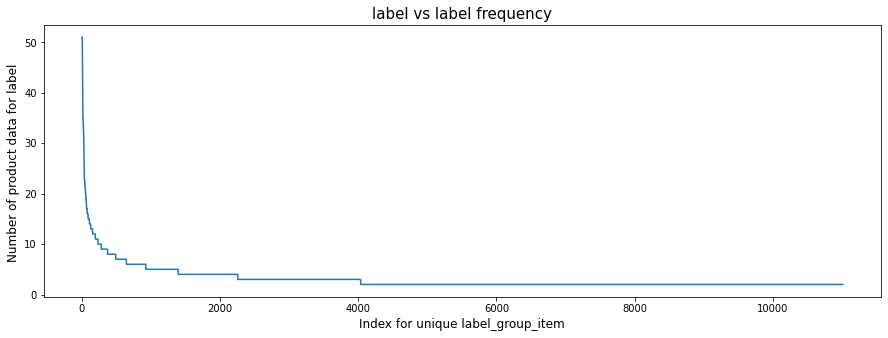

In [7]:
train_df=pd.read_csv('../input/shopee-product-matching/train.csv')
labelGroups = train_df.label_group.value_counts()
# print(labelGroups)
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(labelGroups)), labelGroups.values)
plt.xlabel("Index for unique label_group_item", size=12)
plt.ylabel("Number of product data for label ", size=12)
plt.title("label vs label frequency", size=15)
plt.show()

In [8]:
import time
import datetime
start_time = time.time()
print(datetime.datetime.now())

2022-09-24 01:05:46.110987


# Create Custom DataSet

In [9]:
class ShopeeTitleDataset(Dataset):
    
    def __init__(self, df,text_col,label_col, COMPUTE_CV=False, transform=None):
        self.df = df        
        texts = df[text_col]
        self.labels = df[label_col].values
        self.titles = []
        
        for title in texts:
            title = title.encode('utf-8').decode("unicode_escape")
            title = title.encode('ascii', 'ignore').decode("unicode_escape")
            title = title.lower()
            self.titles.append(title)
    
    def __len__(self):
        return len(self.titles)
    
    def __getitem__(self, idx):       
        text = self.titles[idx]
        label = torch.tensor(self.labels[idx])
        return text, label
            




# Build Model

In [10]:
class ArcFaceModule(nn.Module):
    def __init__(self, in_features, out_features, scale=30, margin=0.5, easy_margin=False, ls_eps=0.0 ):
        super(ArcFaceModule, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.easy_margin=easy_margin
        self.ls_eps=ls_eps
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin
        
        
        
    
    def forward(self, input, label):
        
        # cosine = X.W = ||X|| .||W|| . cos(theta) 
        # if X and W are normalize then dot product X, W = will be cos theta
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        # sin(theta)^2 = 1 - cos(theta)^2
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        # phi = cos(theta + margin) = cos theta . cos(margin) -  sine theta .  sin(margin)
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
#             print(type(cosine), type(phi), type(self.mm), type(self.th))
#             print(cosine.dtype, phi.dtype, self.mm.dtype, self.th.dtype)
            # torch.tensor(a,dtype=torch.float16)
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
            
        
        one_hot = torch.zeros(cosine.size(), device=CFG.device)
        # one hot encoded
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        #  output = label == True ? phi : cosine  
        # Add Margin to true label direction only 
        # Add normal cosine to other class weight direction
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        # scale the output
        output *= self.scale
        # return cross entropy loss on scalled output
        return output, nn.CrossEntropyLoss()(output,label)

In [11]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    # First element of model_output contains all token embeddings
    token_embeddings = model_output[0]  
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [12]:
   
    
    
class ShopeeBertEncoder(nn.Module):
    
    def __init__(self,
                     model_name=CFG.bert_model_name,
                     loss_fn='ArcFace',
                     classes = CFG.classes,
                     fc_dim = CFG.fc_dim,
                     pretrained=True,
                     use_fc=True,
                     COMPUTE_CV=CFG.COMPUTE_CV,
                     margin = CFG.margin,
                    scale = CFG.scale,
                ):
        
        super(ShopeeBertEncoder,self).__init__()
        print("Building Model Backbone for {}".format(model_name))
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # create bottlenack backbone network from pretrained model 
        self.backbone = AutoModel.from_pretrained(model_name).to(CFG.device)
        in_features = 768
        self.use_fc = use_fc
        
        
        # build top fc layers
        # (Embedding that we are looking at testing time to represent the entire Text)
        if use_fc:
            self.dropout = nn.Dropout(p=0.0)
            self.classifier = nn.Linear(in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self.init_params()
            in_features = fc_dim

        if loss_fn=='softmax':
            self.final = nn.Linear(in_features, CFG.classes)
        elif loss_fn =='ArcFace':
            self.final = ArcFaceModule( in_features,
                                        CFG.classes,
                                        scale = scale,
                                        margin = margin,
                                        easy_margin = False,
                                        ls_eps = 0.0)
            
    def forward(self, texts, labels=torch.tensor([0])):
        features = self.get_features(texts)
        if self.training:
            logits = self.final(features,  labels.to(CFG.device))
            return logits
        else:
            return features
    
    def init_params(self):
        nn.init.xavier_normal_(self.classifier.weight)
        nn.init.constant_(self.classifier.bias,0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)
        
        
    def get_features(self,texts):
        
        encoding = self.tokenizer(texts, 
                                  padding=True,
                                  truncation=True,
                                  max_length = CFG.max_length,
                                  return_tensors='pt').to(CFG.device)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        
        embedding = self.backbone(input_ids, attention_mask=attention_mask)
        x = mean_pooling(embedding, attention_mask)
        
        if self.use_fc and self.training:
            x = self.dropout(x)
            x = self.classifier(x)
            x = self.bn(x)
            
        return x
    
    
# shoppe_label_classfier = ShopeeLabelGroupClassfier()


# Custom Learning Rate Scheduler

In [13]:
import torch 
from torch.optim.lr_scheduler import _LRScheduler


class ShopeeScheduler(_LRScheduler):
    def __init__(self, optimizer, lr_start=5e-6, lr_max=1e-5,
                 lr_min=1e-6, lr_ramp_ep=5, lr_sus_ep=0, lr_decay=0.4,
                 last_epoch=-1):
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.lr_ramp_ep = lr_ramp_ep
        self.lr_sus_ep = lr_sus_ep
        self.lr_decay = lr_decay
        super(ShopeeScheduler, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        if self.last_epoch == 0:
            self.last_epoch += 1
            return [self.lr_start for _ in self.optimizer.param_groups]
        lr = self._compute_lr_from_epoch()
        self.last_epoch += 1
        return [lr for _ in self.optimizer.param_groups]
    
    def _get_closed_form_lr(self):
        return self.base_lrs
    
    def _compute_lr_from_epoch(self):
        if self.last_epoch < self.lr_ramp_ep:
            lr = ((self.lr_max - self.lr_start) / 
                  self.lr_ramp_ep * self.last_epoch + 
                  self.lr_start)
        elif self.last_epoch < self.lr_ramp_ep + self.lr_sus_ep:
            lr = self.lr_max
        else:
            lr = ((self.lr_max - self.lr_min) * self.lr_decay**
                  (self.last_epoch - self.lr_ramp_ep - self.lr_sus_ep) + 
                  self.lr_min)
        return lr

# SetUp : Data

In [14]:
df = pd.read_csv(TRAIN_CSV)
# df['target']=
grp_dict=df.groupby('label_group').posting_id.agg('unique').to_dict()
df['target'] = df.label_group.map(grp_dict)
df.head()

,posting_id,image,image_phash,title,label_group,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"


In [15]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=CFG.n_splits)

df['fold'] = -1

for i, (train_ids, valid_ids) in enumerate(gkf.split(X=df, groups=df['label_group'])):
    df.loc[valid_ids,'fold'] =  i
    
labelencoder= LabelEncoder()
df['label_group'] = labelencoder.fit_transform(df['label_group'])
df.head(5)




,posting_id,image,image_phash,title,label_group,target,fold
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666,"[train_129225211, train_2278313361]",0
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572,"[train_3386243561, train_3423213080]",1
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,6172,"[train_2288590299, train_3803689425]",0
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,10509,"[train_2406599165, train_3342059966]",2
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,9425,"[train_3369186413, train_921438619]",0


In [16]:
if CFG.COMPUTE_CV:
    fold = 3
    train_df = df[df['fold']!=fold].reset_index(drop=True)
    valid_df = df[df['fold']==fold].reset_index(drop=True)
    print("Train Data length =", len(train_df))
    print("Train Data classes =", len(train_df['label_group'].unique()))
    print("Valid Data length =", len(valid_df))
    print("Valid Data classes =", len(valid_df['label_group'].unique()))
else:
    train_df = df.copy()
    valid_df = pd.DataFrame()
    print("Train Data length =", len(train_df))
    print("Train Data classes =", len(train_df['label_group'].unique()))

Train Data length = 25687
Train Data classes = 8260
Valid Data length = 8563
Valid Data classes = 2754


In [17]:
train_dataset = ShopeeTitleDataset(train_df,'title','label_group')

train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size,
                          drop_last=True,pin_memory=True, shuffle = True)

if CFG.COMPUTE_CV:
    valid_dataset = ShopeeTitleDataset(valid_df,'title','label_group')

    valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.batch_size,
                          drop_last=False,pin_memory=True, shuffle = False)
    

# Training  Single Epoch


In [18]:
def training_one_epoch(epoch,model, dataloader,optimizer, scheduler, device, loss_criteria):
    avg_trian_loss = 0.0
    # put model in traning model
    model.train()
    
    if CFG.use_auto_mix_precision:
        scaler = torch.cuda.amp.GradScaler()
    
    tq = tqdm(enumerate(dataloader), total=len(dataloader), desc = "Training epoch: " + str(epoch+1), ncols=100)
    y_true=[]
    y_pred=[]
    for idx, (texts, labels) in tq:
        texts = list(texts)
        # zero out gradient
        optimizer.zero_grad()
        if CFG.use_auto_mix_precision:
            with torch.cuda.amp.autocast():
                # forward pass
                output, loss = model(texts, labels)
                # backward pass loss
                scaler.scale(loss).backward()
                avg_trian_loss+=loss.item()
                # batch accumulation of update
                if (idx+1) % CFG.accum_iter == 0 :
                    scaler.step(optimizer)
                    scaler.update()
        else:
            output, loss = model(texts, labels)
            # backward pass loss
            loss.backward()
            avg_trian_loss+=loss.item()
            # batch accumulation of update
            if (idx+1) % CFG.accum_iter == 0 :
                optimizer.step()
                
        tq.set_postfix({'loss' : '%.6f' %float(avg_trian_loss/(idx+1)), 'LR' : optimizer.param_groups[0]['lr']})            
         
    scheduler.step()
    
    return  model, avg_trian_loss / len(dataloader)
        

    
    

# Get BERT Embeddings

In [19]:
def get_bert_Embeddings(df, col, model, chunk=32):
    
    # this is costly GPU operation so we need to be very careful
    # put model in evalution mode
    model.eval()
    bert_embeddings = torch.zeros((df.shape[0], 768)).to(CFG.device)
    for i in tqdm(list(range(0, df.shape[0], chunk)) + [df.shape[0]-chunk], desc="get_bert_embeddings", ncols=80):
        
        titles = []
        
        # get title chunk wise
        for title in df[col][i:i+chunk].values:
            try:
                # preprocess title before passing through tokenization part
                title = title.encode('utf-8').decode("unicode_escape")
                title = title.encode('ascii', 'ignore').decode("unicode_escape")
                
            except Exception:
                raise Exception("Title Processing Error")
                
            title = title.lower()
            titles.append(title)
        # get bert embedding by forward pass chunk by chunk
        with torch.no_grad():
            if CFG.use_auto_mix_precision:
                with torch.cuda.amp.autocast():
                    model_output = model(titles)
            else:
                model_output = model(titles)
        
        bert_embeddings[i:i+chunk] = model_output  
        
    del model, titles, model_output

    gc.collect()
    torch.cuda.empty_cache()

    return bert_embeddings
                    
    
    

In [20]:
def get_neighbors(df, embeddings, k=15,threshold=0.0, metric='cosine'):
    
    knn_model = NearestNeighbors( n_neighbors=k, metric=metric)
    knn_model.fit(embeddings)
    # For each of the Posting get top 50 nearest neighbors, it's distances and indices
    distances, indices = knn_model.kneighbors(embeddings)
    preds = []
    
    for i in range(embeddings.shape[0]):
        # get all the neighbors which has distance less than some threshold
        idx = np.where(distances[i,] < threshold)[0]
        # get all indices for current posting 
        ids = indices[i,idx] 
        # retrive posting ids from ids
        posting_ids = df['posting_id'].iloc[ids].values
        preds.append(posting_ids)
        
    del knn_model, distances, indices
    gc.collect()
    return preds
        
    

In [21]:
def getMetric(col):
    # intersection over union
    def f1score(row):
        n = len(np.intersect1d(row.target, row[col]))
        return 2 * n / (len(row.target) + len(row[col]))
    return f1score

# Training Loop

In [22]:
CFG.epochs =7
max_f1_valid=0


In [23]:
def run_training(model=None, history=None):
    
    # define loss function
    loss_criteria = nn.CrossEntropyLoss()
    loss_criteria.to(CFG.device)
    # define model
    
    if not model:
        model = ShopeeBertEncoder()
        model.to(CFG.device);
    
    # define optimzer
    optimizer_grouped_parameters = [
    {'params': model.backbone.parameters(), 'lr': CFG.bert_scheduler_params['lr_start']},
    {'params': model.classifier.parameters(), 'lr': CFG.bert_scheduler_params['lr_start'] * 2},
    {'params': model.bn.parameters(), 'lr': CFG.bert_scheduler_params['lr_start'] * 2},
    {'params': model.final.parameters(), 'lr': CFG.bert_scheduler_params['lr_start'] * 2},
]

    optimizer = torch.optim.Adam(optimizer_grouped_parameters,lr= CFG.bert_scheduler_params['lr_start'])

    # learning rate scheudler
    #scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=7, T_mult=1, eta_min=1e-6, last_epoch=-1)
    scheduler = ShopeeScheduler(optimizer, **CFG.bert_scheduler_params)
    if not history:
        history = {'train_loss':[],'validation_loss':[],'train_f1_score':[],'scheduler':[], 'valid_f1_score':[]}
    max_f1_valid = 0
    for epoch in range(CFG.epochs):
        
        # get current epoch training loss
        model, avg_train_loss = training_one_epoch(epoch = epoch,
                                           model = model,
                                           dataloader = train_dataloader,
                                           optimizer = optimizer,
                                           scheduler = scheduler,
                                           device = CFG.device, 
                                           loss_criteria = loss_criteria)
        
        
        # Validation part
        if CFG.COMPUTE_CV:
            valid_embeddings = get_bert_Embeddings(valid_df, 'title', model)
            valid_predictions =get_neighbors(valid_df, valid_embeddings.detach().cpu().numpy(),
                                          k=CFG.bert_knn if len(df) > 3 else 3, threshold=CFG.bert_knn_threshold)
            
            valid_df['oob'] = valid_predictions

            valid_df['f1'] = valid_df.apply(getMetric('oob'), axis=1)
            valid_f1 = valid_df.f1.mean()
            valid_df['oob'] = 0
            print('Valid f1 score =', valid_f1)
            if (epoch >= CFG.min_save_epoch) and (valid_f1 > max_f1_valid):
                print(f"[{datetime.datetime.now()}] Valid f1 score improved. Saving model weights to {CFG.save_model_path}")
                max_f1_valid = valid_f1
                torch.save(model.state_dict(), CFG.save_model_path)
            
        else:
            if (epoch == CFG.epochs - 1):
                print(f"[{datetime.datetime.now()}] Saving model weights to {CFG.save_model_path}")
                torch.save(model.state_dict(), CFG.save_model_path)


            
        
        print("Epoch : {} avg Validation f1 {}".format(epoch+1,valid_f1))
        
        history['train_loss'].append(avg_train_loss)
        history['valid_f1_score'].append(valid_f1)
        history['scheduler'].append(scheduler.state_dict())
        
    
        
        
    return model, history

In [24]:
model, history = run_training()

Building Model Backbone for ../input/bertmodel/paraphrase-xlm-r-multilingual-v1


get_bert_embeddings: 100%|████████████████████| 269/269 [00:09<00:00, 29.06it/s]


Valid f1 score = 0.18228139336725555
Epoch : 1 avg Validation f1 0.18228139336725555


get_bert_embeddings: 100%|████████████████████| 269/269 [00:09<00:00, 29.01it/s]


Valid f1 score = 0.5780710548126888
Epoch : 2 avg Validation f1 0.5780710548126888


get_bert_embeddings: 100%|████████████████████| 269/269 [00:09<00:00, 29.06it/s]


Valid f1 score = 0.6892369347154987
[2022-09-24 01:15:48.054117] Valid f1 score improved. Saving model weights to ./paraphrase-xlm-r-multilingual-v1_epoch7-bs16x1.pt
Epoch : 3 avg Validation f1 0.6892369347154987


get_bert_embeddings: 100%|████████████████████| 269/269 [00:09<00:00, 29.01it/s]


Valid f1 score = 0.7635640788573648
[2022-09-24 01:19:04.481020] Valid f1 score improved. Saving model weights to ./paraphrase-xlm-r-multilingual-v1_epoch7-bs16x1.pt
Epoch : 4 avg Validation f1 0.7635640788573648


get_bert_embeddings: 100%|████████████████████| 269/269 [00:09<00:00, 28.99it/s]


Valid f1 score = 0.7904548216197691
[2022-09-24 01:22:21.123945] Valid f1 score improved. Saving model weights to ./paraphrase-xlm-r-multilingual-v1_epoch7-bs16x1.pt
Epoch : 5 avg Validation f1 0.7904548216197691


get_bert_embeddings: 100%|████████████████████| 269/269 [00:09<00:00, 28.99it/s]


Valid f1 score = 0.7948752105661129
[2022-09-24 01:25:38.137379] Valid f1 score improved. Saving model weights to ./paraphrase-xlm-r-multilingual-v1_epoch7-bs16x1.pt
Epoch : 6 avg Validation f1 0.7948752105661129


get_bert_embeddings: 100%|████████████████████| 269/269 [00:09<00:00, 29.03it/s]


Valid f1 score = 0.7973646848031729
[2022-09-24 01:28:55.261423] Valid f1 score improved. Saving model weights to ./paraphrase-xlm-r-multilingual-v1_epoch7-bs16x1.pt
Epoch : 7 avg Validation f1 0.7973646848031729


# Cross Validation To Find :  Best K and Best Threshold Value

In [25]:
## SEARCH FOR BEST THRESHOLD VALUE
#
if CFG.COMPUTE_CV:
    search_range = range(30,50,1)
    
#     model.load_state_dict(torch.load(CFG.save_model_path, map_location=CFG.device))
    
    valid_embeddings = get_bert_Embeddings(valid_df, 'title', model)
    best_f1_valid = 0.
    best_threshold = 0.
    for search_threshold in search_range:
        search_threshold = search_threshold / 100
        valid_predictions = get_neighbors(valid_df, 
                                          valid_embeddings.detach().cpu().numpy(),
                                          k=CFG.bert_knn if len(df) > 3 else 3, 
                                          threshold=search_threshold
                                         )
        valid_df['oob'] = valid_predictions
        valid_f1 = valid_df.apply(getMetric('oob'), axis=1)
        valid_f1 = valid_df.f1.mean()
        valid_df['oob'] = 0
        
        print(f" Threshold = {search_threshold} => F1 Score = {valid_f1}" )
        if valid_f1 > best_f1_valid:
            best_f1_valid = valid_f1
            best_threshold = search_threshold
            
    print("Best threshold =", best_threshold)
    print("Best f1 score =", best_f1_valid)
    BEST_THRESHOLD = best_threshold
            

get_bert_embeddings: 100%|████████████████████| 269/269 [00:09<00:00, 29.00it/s]


 Threshold = 0.3 => F1 Score = 0.7973646848031729
 Threshold = 0.31 => F1 Score = 0.7973646848031729
 Threshold = 0.32 => F1 Score = 0.7973646848031729
 Threshold = 0.33 => F1 Score = 0.7973646848031729
 Threshold = 0.34 => F1 Score = 0.7973646848031729
 Threshold = 0.35 => F1 Score = 0.7973646848031729
 Threshold = 0.36 => F1 Score = 0.7973646848031729
 Threshold = 0.37 => F1 Score = 0.7973646848031729
 Threshold = 0.38 => F1 Score = 0.7973646848031729
 Threshold = 0.39 => F1 Score = 0.7973646848031729
 Threshold = 0.4 => F1 Score = 0.7973646848031729
 Threshold = 0.41 => F1 Score = 0.7973646848031729
 Threshold = 0.42 => F1 Score = 0.7973646848031729
 Threshold = 0.43 => F1 Score = 0.7973646848031729
 Threshold = 0.44 => F1 Score = 0.7973646848031729
 Threshold = 0.45 => F1 Score = 0.7973646848031729
 Threshold = 0.46 => F1 Score = 0.7973646848031729
 Threshold = 0.47 => F1 Score = 0.7973646848031729
 Threshold = 0.48 => F1 Score = 0.7973646848031729
 Threshold = 0.49 => F1 Score = 0

In [26]:
## SEARCH FOR BEST K VALUE
BEST_THRESHOLD  = 0
if CFG.COMPUTE_CV:
    search_range = range(40,80,2)
    
#     model.load_state_dict(torch.load(CFG.save_model_path, map_location=CFG.device))
    
    valid_embeddings = get_bert_Embeddings(valid_df, 'title', model)
    best_f1_valid = 0.
    best_knn = 0.
    for k in search_range:
        
        valid_predictions = get_neighbors(valid_df, 
                                          valid_embeddings.detach().cpu().numpy(),
                                          k, 
                                          threshold=BEST_THRESHOLD
                                         )
        valid_df['oob'] = valid_predictions
        valid_f1 = valid_df.apply(getMetric('oob'), axis=1)
        valid_f1 = valid_df.f1.mean()
        valid_df['oob'] = 0
        
        print(f" K = {k} =>  F1 Score {valid_f1}" )
        if valid_f1 > best_f1_valid:
            best_f1_valid = valid_f1
            best_knn = k
            
    print("Best K Value =", best_knn)
    print("Best f1 score =", best_f1_valid)
    BEST_K = best_knn
            

get_bert_embeddings: 100%|████████████████████| 269/269 [00:09<00:00, 28.86it/s]


 K = 40 =>  F1 Score 0.7973646848031729
 K = 42 =>  F1 Score 0.7973646848031729
 K = 44 =>  F1 Score 0.7973646848031729
 K = 46 =>  F1 Score 0.7973646848031729
 K = 48 =>  F1 Score 0.7973646848031729
 K = 50 =>  F1 Score 0.7973646848031729
 K = 52 =>  F1 Score 0.7973646848031729
 K = 54 =>  F1 Score 0.7973646848031729
 K = 56 =>  F1 Score 0.7973646848031729
 K = 58 =>  F1 Score 0.7973646848031729
 K = 60 =>  F1 Score 0.7973646848031729
 K = 62 =>  F1 Score 0.7973646848031729
 K = 64 =>  F1 Score 0.7973646848031729
 K = 66 =>  F1 Score 0.7973646848031729
 K = 68 =>  F1 Score 0.7973646848031729
 K = 70 =>  F1 Score 0.7973646848031729
 K = 72 =>  F1 Score 0.7973646848031729
 K = 74 =>  F1 Score 0.7973646848031729
 K = 76 =>  F1 Score 0.7973646848031729
 K = 78 =>  F1 Score 0.7973646848031729
Best K Value = 40
Best f1 score = 0.7973646848031729


In [27]:
end_time = time.time()
time_elapsed=end_time - start_time
print('Elapsed time: {:.0f} min {:.0f} sec'.format(time_elapsed // 60, time_elapsed % 60))
print(datetime.datetime.now())

Elapsed time: 25 min 49 sec
2022-09-24 01:31:34.884433


# Plot Training and Validation Loss and Accuracy

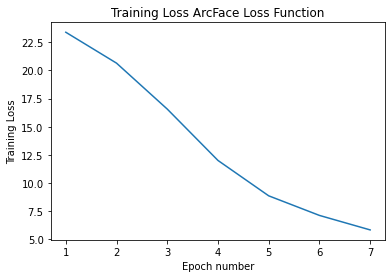

In [28]:
if CFG.COMPUTE_CV:
    epoch_lst = [ i+1 for i in range(CFG.epochs)]
    plt.plot(epoch_lst,history['train_loss'])

    plt.xlabel("Epoch number")
    plt.ylabel('Training Loss')
    plt.title('Training Loss ArcFace Loss Function')
    plt.show()

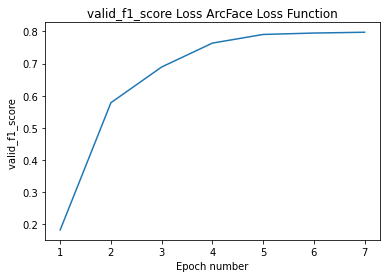

In [29]:
if CFG.COMPUTE_CV:
    plt.plot(epoch_lst,history['valid_f1_score'])
    plt.xlabel("Epoch number")
    plt.ylabel('valid_f1_score ')
    plt.title('valid_f1_score Loss ArcFace Loss Function')
    plt.show()